In [2]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import os
import IPython
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions import Uniform
from delphi.stats.linear_regression import TruncatedLinearRegression
from delphi.oracle import Left, Interval
import delphi.utils.constants as consts

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

STORE_PATH = '/home/gridsan/stefanou/Regression/SampleComplexity'
STORE_TABLE_NAME = 'results'

# regression parameters
left = Left(Tensor([0.0]))

# procedure hyperparameters
args = Parameters({ 
    'epochs': 5,
    'workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'samples': 10000, 
    'in_features': 1, 
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-2,
    'shuffle': False, 
    'eps': 1e-5, 
    'custom_lr_multiplier': consts.COSINE,
    'trials': 10,
    'tol': 1e-2,
    'lower': -1, 
    'upper': 1,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
else: 
    args.__setattr__('device', 'cpu')
    print("using cpu...")
args.__setattr__('phi', left)

using cuda...


In [3]:
# distribution for generating ground truth
U = Uniform(args.lower, args.upper)

# increase variance up to 20
for var in range(1, 2):
    # create store and add table
    store = Store(STORE_PATH)

    store.add_table(STORE_TABLE_NAME, { 
        'known_param_mse': float,
        'unknown_param_mse': float,
        'unknown_var_mse': float,
        'ols_param_mse': float,
        'ols_var_mse': float,
        'alpha': float, 
        'var': float, 
    })
    ch.manual_seed(0)
    # generate ground truth
    ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
    ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([1, args.in_features]))) 
    ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([1, 1])))

    # generate data
    X = Uniform(-1, 1).sample(ch.Size([args.samples, args.in_features]))
    y = ground_truth(X) + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([args.samples]))
    # truncate
    indices = args.phi(y).nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = y[indices].detach(), X[indices].detach()
    alpha = Tensor([y_trunc.size(0)/args.samples])

    # empirical linear regression
    ols = LinearRegression() 
    ols.fit(x_trunc, y_trunc)
    ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]

    # truncated linear regression with known noise variance
    trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias, var=ols_var)
    results = trunc_reg.fit(x_trunc, y_trunc)
    w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

    # truncated linear regression with unknown noise variance
    trunc_reg = TruncatedLinearRegression(phi=args.phi, alpha=alpha, args=args, bias=args.bias)
    results = trunc_reg.fit(x_trunc, y_trunc)
    var_ = results.lambda_.inverse().detach()
    w, w0 = (results.v.detach()*var_).cpu(), (results.bias.detach()*var_).cpu()

    # parameter estimates 
    real_params = ch.cat([ground_truth.weight.T, ground_truth.bias])
    ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_).unsqueeze(0)])
    unknown_params = ch.cat([w, w0])
    known_params = ch.cat([w_.T, w0_.unsqueeze(0)])

    # metrics
    unknown_param_mse = ch.nn.MSELoss()(unknown_params, real_params)
    unknown_var_mse = ch.nn.MSELoss()(var_, Tensor([var]))
    ols_param_mse = ch.nn.MSELoss()(Tensor(ols_params), Tensor(real_params))
    ols_var_mse = ch.nn.MSELoss()(ols_var, Tensor([var]))
    known_param_mse = ch.nn.MSELoss()(known_params, real_params)

    store[STORE_TABLE_NAME].append_row({ 
        'known_param_mse': known_param_mse,
        'unknown_param_mse': unknown_param_mse,
        'unknown_var_mse': unknown_var_mse,
        'ols_param_mse': ols_param_mse,
        'ols_var_mse': ols_var_mse,
        'alpha': float(alpha.flatten()),
        'var': float(var), 
    })

    IPython.display.clear_output(wait=False)

    # close current store
    store.close()

Logging in: /home/gridsan/stefanou/Regression/SampleComplexity/cdb53fbd-5157-4188-ad59-ba1fc25b4382


KeyboardInterrupt: 

# Results

100%|██████████| 11/11 [00:01<00:00,  8.32it/s]


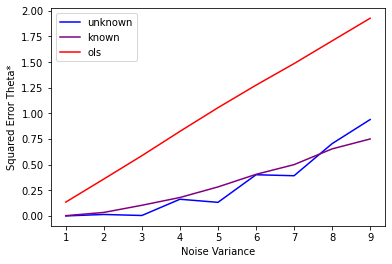

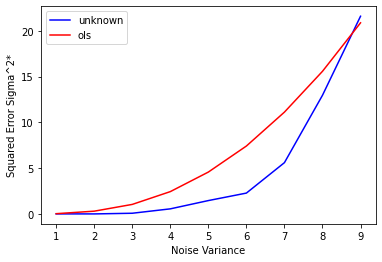

In [9]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()
reader.close() # close reader

# variance vs param mse
sns.lineplot(data=results, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# var vs var mse
ax = sns.lineplot(data=results, x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results, x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

In [5]:
results

,known_param_mse,unknown_param_mse,unknown_var_mse,ols_param_mse,ols_var_mse,alpha,var,exp_id
0,0.003595,0.00127,0.003585,0.135935,0.026892,0.5336,1.0,729b2339-2c08-4785-862f-d8cb97fdecdf


In [6]:
ols_var

tensor([[0.8360]])

In [7]:
var_

tensor([[0.9401]])